Стандартные бибилиотеки

In [1]:
!! pip install pymorphy2  # для лемматизации
!! pip install wordcloud  # для облака слов
!! pip install navec  # аналог glove для русских слов

['Collecting navec',
 '  Downloading navec-0.10.0-py3-none-any.whl.metadata (21 kB)',
 'Requirement already satisfied: numpy in /usr/local/lib/python3.10/dist-packages (from navec) (1.26.4)',
 'Downloading navec-0.10.0-py3-none-any.whl (23 kB)',
 'Installing collected packages: navec',
 'Successfully installed navec-0.10.0']

В папке на диске лежит файл *navec_hudlit_v1_12B_500K_300d_100q.tar* - это русский векторайзер

Скачать и заюзать можете по ссылке https://drive.google.com/file/d/1zkqdVLpmTxT58mOlrD5SYBUvBCwjk1zv/view?usp=sharing

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os

os.chdir(r'/content/gdrive/MyDrive/МТС')
print(os.getcwd())

/content/gdrive/MyDrive/МТС


In [4]:
from sklearn.cluster import KMeans, kmeans_plusplus
from gensim.models import Word2Vec, FastText
from sklearn.decomposition import PCA
from tqdm import tqdm
from wordcloud import WordCloud
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from gensim.models import KeyedVectors
from navec import Navec

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import pymorphy2
import seaborn as sns
import gensim

Убрем здесь стопслова. Осталось придумать, что делать с "не" и отрицательным смыслом

In [5]:
import nltk

# Загрузка необходимых данных
nltk.download('stopwords')

# Получение списка русских стоп-слов
from nltk.corpus import stopwords
stopwords_ru = stopwords.words("russian")

# Вывод первых 10 стоп-слов
reg_stop = '|'.join(map(lambda x: f'(^{x}$)', stopwords_ru)) + '|(^из-за$)|(^из-под$)|(^.*ий$)' # в стоп-словах не было этих союзов + я убрал прилагательные, так как везде будет "большой", "любимый"
reg_stop

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


'(^и$)|(^в$)|(^во$)|(^не$)|(^что$)|(^он$)|(^на$)|(^я$)|(^с$)|(^со$)|(^как$)|(^а$)|(^то$)|(^все$)|(^она$)|(^так$)|(^его$)|(^но$)|(^да$)|(^ты$)|(^к$)|(^у$)|(^же$)|(^вы$)|(^за$)|(^бы$)|(^по$)|(^только$)|(^ее$)|(^мне$)|(^было$)|(^вот$)|(^от$)|(^меня$)|(^еще$)|(^нет$)|(^о$)|(^из$)|(^ему$)|(^теперь$)|(^когда$)|(^даже$)|(^ну$)|(^вдруг$)|(^ли$)|(^если$)|(^уже$)|(^или$)|(^ни$)|(^быть$)|(^был$)|(^него$)|(^до$)|(^вас$)|(^нибудь$)|(^опять$)|(^уж$)|(^вам$)|(^ведь$)|(^там$)|(^потом$)|(^себя$)|(^ничего$)|(^ей$)|(^может$)|(^они$)|(^тут$)|(^где$)|(^есть$)|(^надо$)|(^ней$)|(^для$)|(^мы$)|(^тебя$)|(^их$)|(^чем$)|(^была$)|(^сам$)|(^чтоб$)|(^без$)|(^будто$)|(^чего$)|(^раз$)|(^тоже$)|(^себе$)|(^под$)|(^будет$)|(^ж$)|(^тогда$)|(^кто$)|(^этот$)|(^того$)|(^потому$)|(^этого$)|(^какой$)|(^совсем$)|(^ним$)|(^здесь$)|(^этом$)|(^один$)|(^почти$)|(^мой$)|(^тем$)|(^чтобы$)|(^нее$)|(^сейчас$)|(^были$)|(^куда$)|(^зачем$)|(^всех$)|(^никогда$)|(^можно$)|(^при$)|(^наконец$)|(^два$)|(^об$)|(^другой$)|(^хоть$)|(^после$)|(^н

In [6]:
reg = r'[^А-Яа-я /-]'
bad_reg = r'(.*ху.*)|(.*пиз.*)|(.*еба.*)|(.*еби.*)' + rf'|{reg_stop}'  # обработаем плохие слова и стоп слова
# На месте words будет чтение файла со словами
words = [
    "Удовольствия", "Интерес", "Удовлетворение", "Признание", "Возможности", 'из-за денег', 'деньги',
    "Достижения", "Стимул", "Призовухи", "Победа", "Увлечение", "Спецуха",
    "Мани", "Люблю", "Вдохновение", "Целеустремленность", "Развитие",
    "Результат", "Отдача", "Полезность", "Вознаграждение", "Доход", "Зарплата",
    "Бабло", "Кайф", "Адреналин", "Самореализация", "Профит", "Карьерный рост",
    "Прорыв", "Движуха", "Бабосики", "Амбиции", "Комфорт", "Успех", "Деньги",
    "Энергия", "Репутация", "Мечта", "Горизонты", "Поддержка", "Мотивация",
    "Перспективы", "Идеи", "Стабильность", "Риск", "Драйв", "Финансы",
    "Проект", "Цель", "Карьера", "Инвестирование", "Материальные блага",
    "Саморазвитие", "Популярность", "Уверенность", "Инициатива", "Хорошие связи",
    "Успешность", "Мобильность", "Таланты", "Командный дух", "Новые знани988я",
    "Навыки", "Социальный статус", "Авторитет", "Эффективность", "Предприимчивость",
    "Желание", "Креатив", "Выгода", "Ответственность", "Важность", "Ресурсы",
    "Обеспеченность", "Статус", "Достоинство", "Дисциплина", "Прогресс",
    "Трудолюбие", "Упорство", "Влияние", "Самостоятельность", "Качество",
    "Искусство", "Производительность", "Профессия", "Долг", "Смысл", "Труд",
    "Занятость", "Гонорар", "Комфорт", "Умения", "Фидбек", "Ответ", "Разнообразие",
    "Порядок", "Отношения", "Честь", "Обучение", "Путешествия", "Эксперименты",
    "Творчество", "Счастье"
]

# Разобьем фразы на отдельные слова
res_words = []
for w in words:
    res_words += w.split()

print(res_words)

words = [re.sub(reg, '', word.lower()) for word in res_words]

['Удовольствия', 'Интерес', 'Удовлетворение', 'Признание', 'Возможности', 'из-за', 'денег', 'деньги', 'Достижения', 'Стимул', 'Призовухи', 'Победа', 'Увлечение', 'Спецуха', 'Мани', 'Люблю', 'Вдохновение', 'Целеустремленность', 'Развитие', 'Результат', 'Отдача', 'Полезность', 'Вознаграждение', 'Доход', 'Зарплата', 'Бабло', 'Кайф', 'Адреналин', 'Самореализация', 'Профит', 'Карьерный', 'рост', 'Прорыв', 'Движуха', 'Бабосики', 'Амбиции', 'Комфорт', 'Успех', 'Деньги', 'Энергия', 'Репутация', 'Мечта', 'Горизонты', 'Поддержка', 'Мотивация', 'Перспективы', 'Идеи', 'Стабильность', 'Риск', 'Драйв', 'Финансы', 'Проект', 'Цель', 'Карьера', 'Инвестирование', 'Материальные', 'блага', 'Саморазвитие', 'Популярность', 'Уверенность', 'Инициатива', 'Хорошие', 'связи', 'Успешность', 'Мобильность', 'Таланты', 'Командный', 'дух', 'Новые', 'знани988я', 'Навыки', 'Социальный', 'статус', 'Авторитет', 'Эффективность', 'Предприимчивость', 'Желание', 'Креатив', 'Выгода', 'Ответственность', 'Важность', 'Ресурсы', 

Лемматизуем

In [7]:
morph = pymorphy2.MorphAnalyzer()

lemmas = [morph.parse(word)[0].normal_form for word in words]

lemmas = [word for word in lemmas if not(re.search(bad_reg, word))]

Создадим модель glove для русских слов (надо подумать, че делать еще для английских и всяких конченых слов по типу бенефиты, плюхи)

In [8]:
from navec import Navec

path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'  # тут укажи путь к тому файлу в системе
navec = Navec.load(path)

arr = []
new_lemmas = []  # я пока что просто кикаю слова, которых нет в базе с путем path. Надо придумать, как обрабатывать незнакомые слова

for word in lemmas:
    try:
        arr.append(navec[word])
        new_lemmas.append(word)
    except:
        continue
word_vectors = np.array(arr)
lemmas = np.array(new_lemmas)

Создадим дефолтный word2vec (это тоже работает, но хуже)

In [155]:
# # Создаем небольшую Word2Vec модель для векторизации слов
# model = Word2Vec([lemmas], vector_size=10, min_count=1)
# #model = FastText([words], vector_size=10, window=5, min_count=1, workers=4)

# # Преобразуем слова в векторное представление
# word_vectors = np.array([model.wv[word] for word in lemmas])

Кластеризуем с помощью kmeans_plusplus и найдем инерцию, по ней определим количество кластеров

In [9]:
ran = range(1, len(lemmas) + 1)
inertia_df = pd.DataFrame(data=[], index=ran, columns=['inertia'])
effective_clusters = -1
for n_clusters in tqdm(ran):
    try:
        effective_clusters += 1
        centers, indices = kmeans_plusplus(np.array(word_vectors), n_clusters=n_clusters, random_state=10)
        kmeans = KMeans(n_clusters=n_clusters,  random_state=42)
        cluster_labels = kmeans.fit_predict(word_vectors)
        inertia_df.loc[n_clusters] = kmeans.inertia_
    except:
        break
inertia_df = inertia_df.iloc[:effective_clusters]

 97%|█████████▋| 104/107 [00:07<00:00,  4.59it/s]/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (104) found smaller than n_clusters (105). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
 98%|█████████▊| 105/107 [00:07<00:00,  4.60it/s]/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (104) found smaller than n_clusters (106). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
 99%|█████████▉| 106/107 [00:07<00:00,  4.55it/s]/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (104) found smaller than n_clusters (107). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
100%|██████████| 107/107 [00:07<00:00, 13.81it/s]


<Axes: >

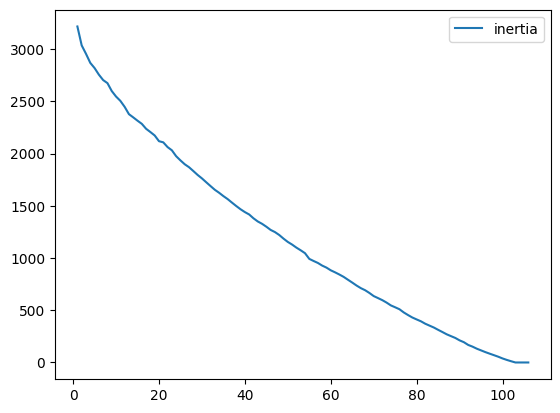

In [10]:
inertia_df.plot()

представим инерцию и ее производную в нормальном виде

In [11]:
inertia_arr = np.array(inertia_df).flatten()
inertia_derivative = inertia_arr[:-1] - inertia_arr[1:]

Тут не пугаться - это просто класс для град спуска

In [12]:
class GradSearch(object):
    def __init__(self, a=1.0, b=0.0, x0=1.0, l=1e-2):
        self.a = a
        self.b = b
        self.x0 = x0
        self.l = l
        self.loss = []

    def f(self, x, y, a, b, x0):
        return 0.5 * pow(y - a * np.exp(-x / x0) - b, 2).sum()

    def dfda(self, x, y, a, b, x0):
        return ((a * np.exp(-x / x0) + b - y) * np.exp(-x / x0)).sum()

    def dfdb(self, x, y, a, b, x0):
        return (a * np.exp(-x / x0) + b - y).sum()

    def dfdx0(self, x, y, a, b, x0):
        return ((a * np.exp(-x / x0) + b - y) * a * np.exp(-x / x0) * x / pow(x0, 2)).sum()

    def fit(self, x, y, epochs=1_000):
        self.loss.append(self.f(x, y, self.a, self.b, self.x0))
        for epoch in tqdm(range(epochs)):
            self.a -= self.l * self.dfda(x, y, self.a, self.b, self.x0)
            self.b -= self.l * self.dfdb(x, y, self.a, self.b, self.x0)
            self.x0 -= self.l* self.dfdx0(x, y, self.a, self.b, self.x0)
            self.loss.append(self.f(x, y, self.a, self.b, self.x0))

    def get_a_b_x0(self):
        return self.a, self.b, self.x0

Идея такая. В физике есть радиус Дебая - такое расстояние, при котором взаимодействие уменьшается в $e$ раз. Дебаевский радиус - эффективный размер распространения взаимодействия. Давайте сделаем то же самое с инерцией - дебаевским расстоянием будет количество кластеров, на котором апроксимированная функцией $f(x)$ инерция будет уменьшаться в $e$ раз.

Изначально я хотел заменить инерцию на более гладкую $f(x) = a \cdot e^{-\frac{x}{x_0}} + b$, где $a, b, x_0$ - настраиваемые параметры - как раз град спуск для них. Но потом подумал, что можно сразу использовать дебаевский формализм к инерции без преобразования.

Использование гладкой $f(x) = a \cdot e^{\frac{x}{x_0}} + b$ позволяет убрать различные выбросы и зигзаги (например, у производной инерции - там ваще свистопляска происходит).

In [13]:
x, y = np.array(range(inertia_df.shape[0])), np.array(inertia_df).flatten()
y_norm = y.max()
y /= y_norm

grad = GradSearch(a=1.0, b=0.0, x0=1.0, l=1e-2)
grad.fit(x, y, epochs=100_000)

100%|██████████| 100000/100000 [00:16<00:00, 6066.28it/s]


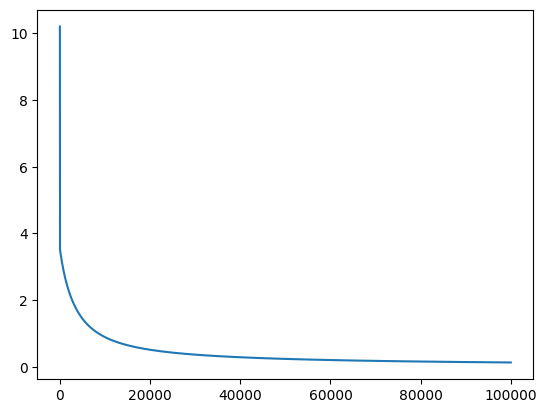

In [14]:
plt.plot(grad.loss)

In [15]:
a, b, x0 = grad.get_a_b_x0()
a, b, x0

(1.036491189116111, 0.014159769702162728, 38.23592018300883)

In [16]:
ind = None
porog = (a + b) / np.e
#porog = inertia_arr[0] / np.e * 2  # если хотим юзать инерцию в чистом виде
for i, arg in enumerate(x):
    if a * np.exp(- arg / x0) + b < porog:
    #if inertia_arr[i] < porog:  # аналогично
        ind = i
        break
ind

40

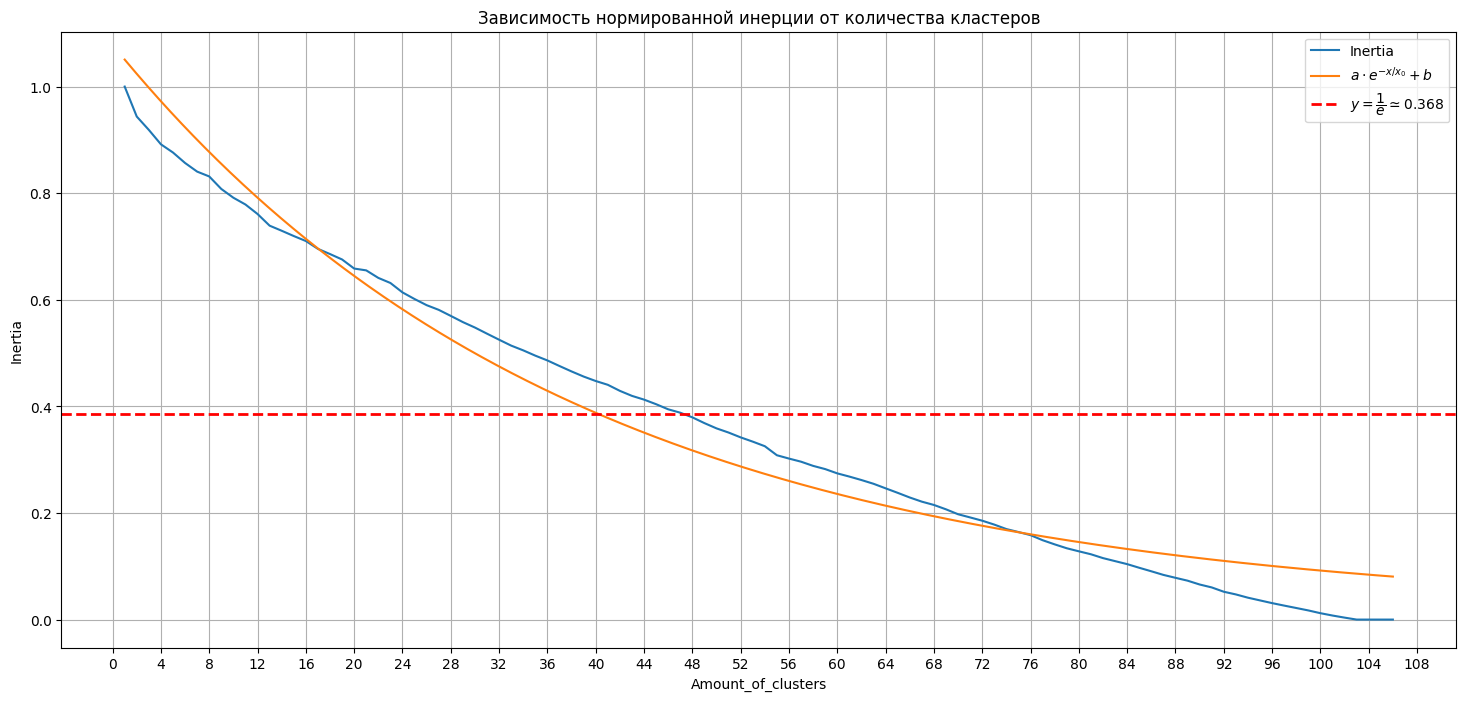

In [35]:
t = np.linspace(x.min(), x.max(), 1000)
y_pred = a * np.exp(-t / x0) + b

plt.figure(figsize=(18, 8))
plt.title('Зависимость нормированной инерции от количества кластеров')
plt.plot(x + 1, y.flatten(), label='Inertia')
plt.plot(t + 1, y_pred, label='$a \cdot e^{-x/x_0} + b$')
plt.axhline(y=(a + b) / np.e, color='r', linestyle='--', linewidth=2, label='$y = \dfrac{1}{e} \simeq 0.368$')
plt.xticks(range(0, inertia_arr[1:].shape[0] + 4, 4))
plt.xlabel('Amount_of_clusters')
plt.ylabel('Inertia')
plt.legend()
plt.grid()

Кластеризуем в соответствии с найденными кластерами

In [36]:
n_clusters = ind + 1
centers, indices = kmeans_plusplus(np.array(word_vectors), n_clusters=n_clusters, random_state=10)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(word_vectors)

df = pd.DataFrame(lemmas, columns=['word'])
df['cluster'] = cluster_labels

Визуализируем (в **seaborn** конечно же)

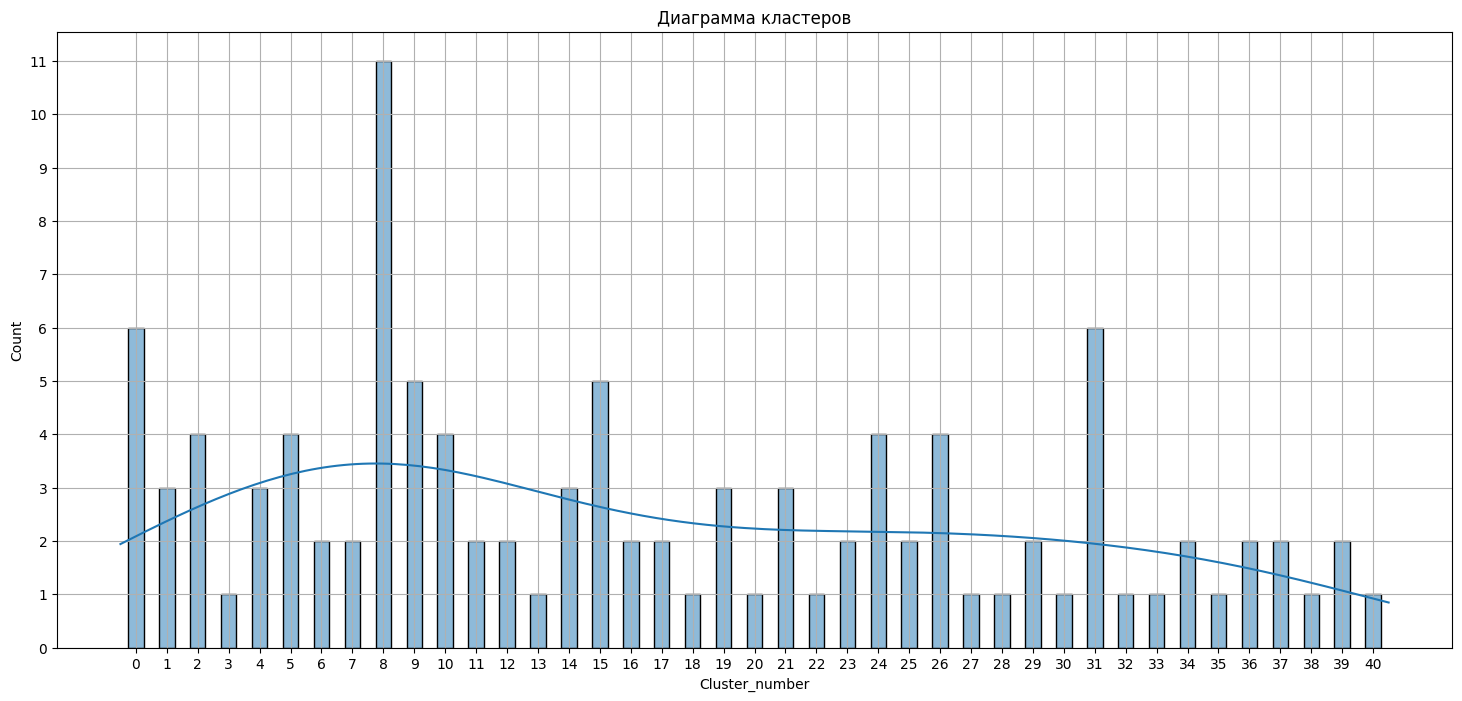

In [43]:
plt.figure(figsize=(18, 8))
ax = sns.histplot(cluster_labels, bins=n_clusters, shrink=0.5, kde=True)

# Получаем положение каждого столбца
bin_edges = ax.patches[0].get_bbox().bounds

# Получаем центры столбцов
centers = [patch.get_x() + patch.get_width() / 2 for patch in ax.patches]

plt.title('Диаграмма кластеров')
# Устанавливаем тики в центре каждого столбца
plt.xticks(centers, np.arange(n_clusters))
plt.yticks(range(12))
plt.xlabel('Cluster_number')
plt.grid()

# Отображение графика
plt.show()

Выберем рандомное слово в каждом кластере и посчитаем сколько слов всего в кластере

In [45]:
counter = {}
for i in range(n_clusters):
    w = np.random.choice(df[df['cluster'] == i]['word'])
    amount = df[df['cluster'] == i].shape[0]
    counter[w] = amount
counter

{'дисциплина': 6,
 'результат': 3,
 'деньга': 4,
 'долг': 1,
 'ресурс': 3,
 'предприимчивость': 4,
 'знание': 2,
 'творчество': 2,
 'карьерный': 11,
 'благо': 5,
 'победа': 4,
 'упорство': 2,
 'перспектива': 2,
 'горизонт': 1,
 'мобильность': 3,
 'желание': 5,
 'комфорт': 2,
 'карьера': 2,
 'обеспеченность': 1,
 'ответственность': 3,
 'финансы': 1,
 'статус': 3,
 'увлечение': 1,
 'вознаграждение': 2,
 'ответ': 4,
 'новый': 2,
 'навык': 4,
 'энергия': 1,
 'путешествие': 1,
 'самореализация': 2,
 'порядок': 1,
 'обучение': 6,
 'адреналин': 1,
 'профессия': 1,
 'зарплата': 2,
 'уверенность': 1,
 'достоинство': 2,
 'отношение': 2,
 'связь': 1,
 'мечта': 2,
 'занятость': 1}

Визуализируем

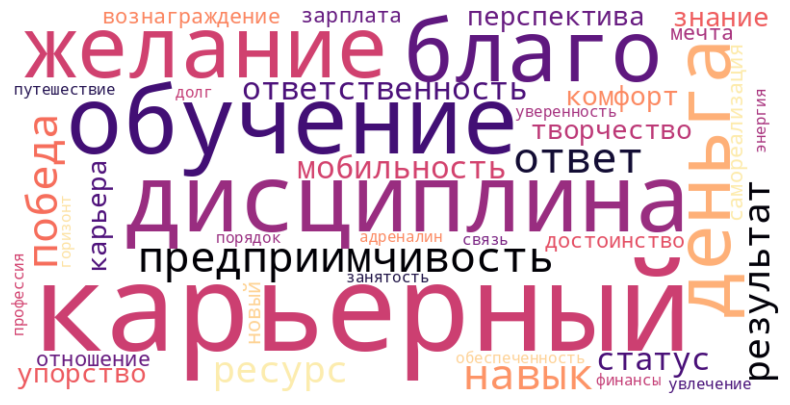

In [52]:
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma').generate_from_frequencies(counter)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()